# Run MCMC sampling
# Heavy nonminimal, fitting log(m_4), log(m_z)

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np

from Likelihood import LEff
from mcmc_utils import heavy_nonminimal_mcmc

from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
hierarchy = 'heavy'
D_or_M = 'majorana'
distance = 'log'
smoothing_pars = (0.1, 0.1)

selection = 'cut_based'
set_backend = True
reset_backend = False
n_samples = 1

spec = 'nonminimal with logs'

In [4]:
this_dark_nus_mcmc = heavy_nonminimal_mcmc(hierarchy, D_or_M, title_addition=spec,
                                   distance=distance, smoothing_pars=smoothing_pars)
df = this_dark_nus_mcmc.provide_df(selection)

heavy majorana


In [8]:
ndim = 4
from ctau_utils import ctau_heavy
def heavy_nonminimal_posterior(parameters):
    '''Posterior in the nonminimal model: parameters = [m4, mz, log10_mu_Vmu4_alpha_epsilon2, log10_Valpha4_alpha_epsilon2]
       It uses global pars to speed up parallel computation'''
    if (parameters[0] < np.log10(this_dark_nus_mcmc.exp_analysis_obj.m4_limits[0])) or\
       (parameters[0] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.m4_limits[1])) or\
       (parameters[1] < np.log10(this_dark_nus_mcmc.exp_analysis_obj.mz_limits[0])) or\
       (parameters[1] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.mz_limits[1])) or\
       (parameters[0] >= parameters[1]) or\
       (parameters[2] <= np.log10(this_dark_nus_mcmc.exp_analysis_obj.lower_bound_Vmu4_alpha_epsilon2)) or\
       (parameters[2] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.upper_bound_Vmu4_alpha_epsilon2)) or\
       (parameters[3] < parameters[2]) or\
       (parameters[3] > np.log10(this_dark_nus_mcmc.exp_analysis_obj.upper_bound_Valpha4_alpha_epsilon2)):
        return -np.inf, -np.inf, -np.inf, -np.inf
    else:
        actual_m4 = 10**parameters[0]
        actual_mz = 10**parameters[1]
        actual_Vmu4_alpha_epsilon2 = 10**parameters[2]
        actual_Valpha4_alpha_epsilon2 = 10**parameters[3]
        ctau = ctau_heavy(actual_m4, 
                          actual_mz, 
                          actual_Valpha4_alpha_epsilon2, 
                          D_or_M)
        this_mu = actual_Vmu4_alpha_epsilon2/this_dark_nus_mcmc.exp_analysis_obj.Vmu4_alpha_epsilon2
        mu, sigma2 = this_dark_nus_mcmc.exp_analysis_obj.kde_n_events(df=df,
                                                         m4mz=(actual_m4, actual_mz),
                                                         ctau=ctau,
                                                         mu=this_mu,
                                                         distance=this_dark_nus_mcmc.distance,
                                                         smoothing=this_dark_nus_mcmc.smoothing_pars)
        return LEff(0, mu, sigma2), mu, sigma2, ctau

labels = ['log10_m4', 'log10_mz', 'log10_Vmu4_alpha_epsilon2', 'log10_Valpha4_alpha_epsilon2']
blobs_dtype = [('mu', float), ('sigma2', float), ('ctau', float)]

In [9]:
this_dark_nus_mcmc.set_posterior(heavy_nonminimal_posterior, 
                                 ndim, 
                                 labels=labels)

In [10]:
n_walkers = ndim**2
with Pool() as pool:
    this_dark_nus_mcmc.initialise_mcmc(n_walkers, pool,
                                       set_backend=set_backend, reset_backend=reset_backend, 
                                       blobs_dtype=blobs_dtype, log_ms=True)
    this_dark_nus_mcmc.run_mcmc(n_samples)

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
N/50 = 0;
tau: [1.92484299 2.09370325 2.13127484 1.59925831]
N/50 = 1;
tau: [4.66778439 4.75918846 4.61572116 5.12349776]
N/50 = 2;
tau: [ 9.1974402  10.39421316  9.08613596 10.32081154]
N/50 = 4;
tau: [21.35450406 21.84541122 20.58900532 17.27424758]
N/50 = 9;
tau: [40.56410209 42.19204458 36.0422805  43.47377326]
N/50 = 20;
tau: [77.92354174 72.31650276 95.5397379  81.04231333]
N/50 = 42;
tau: [114.33378667 139.58079907 135.94031087 133.05703667]
N/50 = 91;
tau: [177.23357106 189.17862793 203.18099884 174.57338533]
N/50 = 196;
tau: [243.367706   227.97712528 239.45920757 210.07919742]


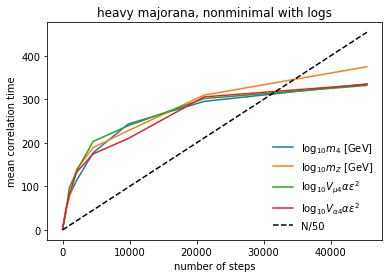

In [11]:
this_dark_nus_mcmc.compute_autocorrelation_time(store=True)

In [12]:
this_dark_nus_mcmc.get_samples(discard=2)

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<Figure size 1080x504 with 5 Axes>,
 array([<AxesSubplot:ylabel='$\\log_{10}m_4$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}m_Z$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\mu 4}\\alpha \\epsilon^2$'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\alpha 4}\\alpha \\epsilon^2$'>,
        <AxesSubplot:xlabel='step number', ylabel='log(p)'>], dtype=object))

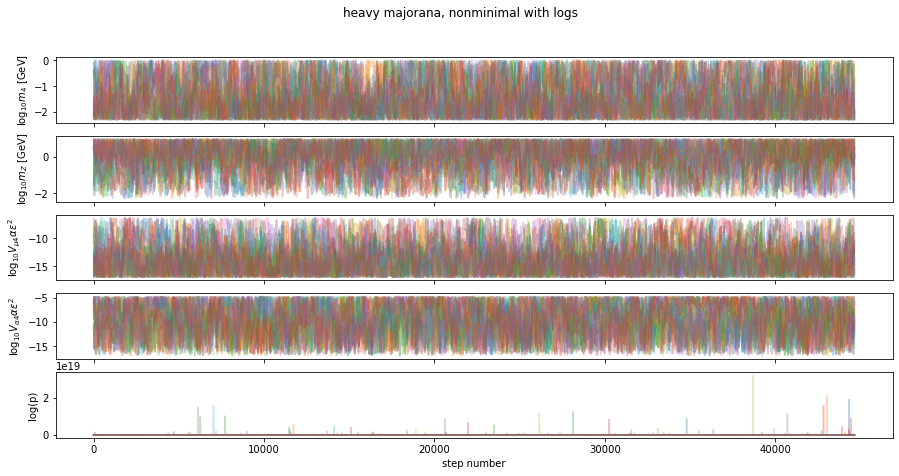

In [13]:
this_dark_nus_mcmc.plot_chains(store=True)

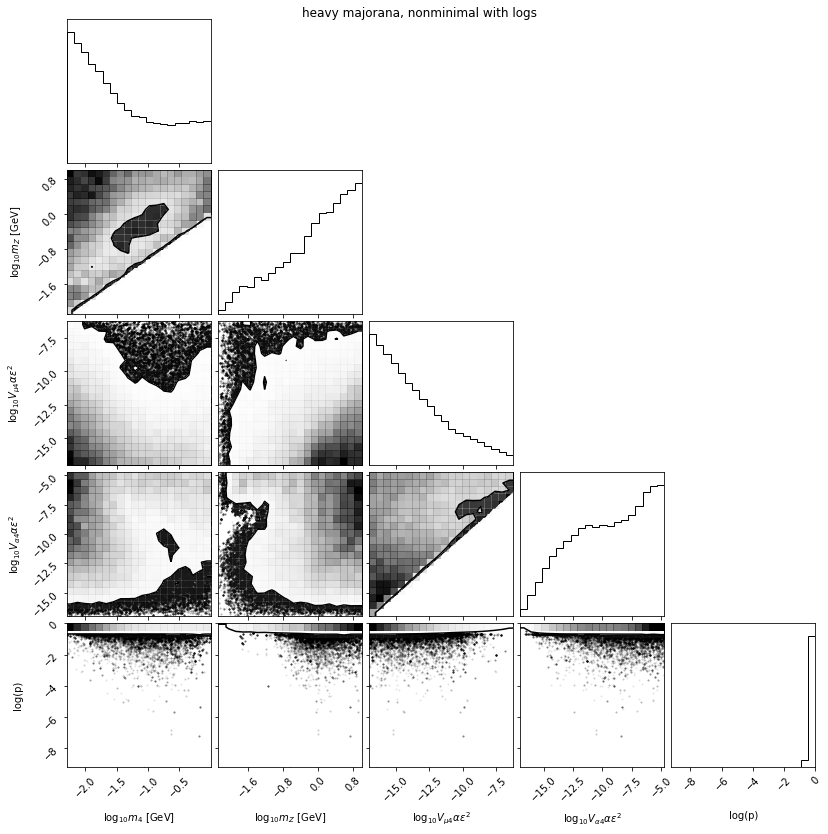

In [14]:
this_dark_nus_mcmc.corner_plot_raw(savefile='raw_corner')

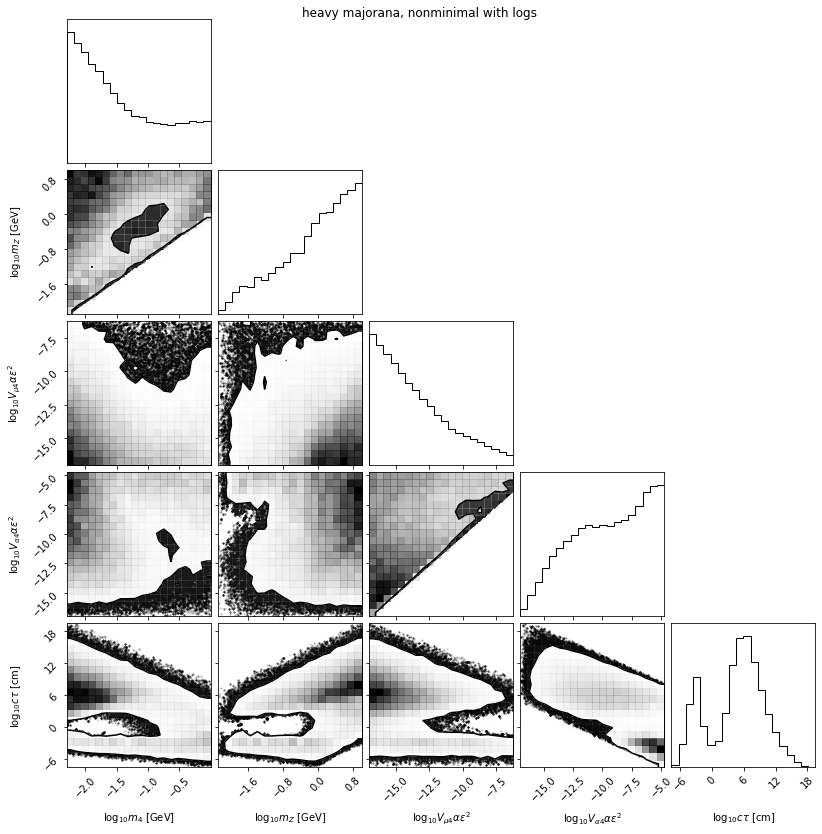

In [15]:
this_dark_nus_mcmc.corner_plot_physics(savefile='physics_corner')

In [16]:
print('Fraction of samples with null expectation =', (this_dark_nus_mcmc.samples['mu'] == 0).sum()/len(this_dark_nus_mcmc.samples))

Fraction of samples with null expectation = 0.8261243786107753


Removed no burn in


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


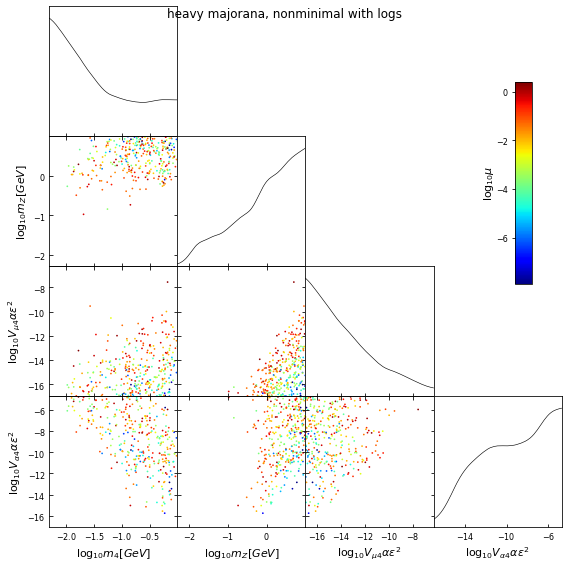

In [17]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_mu', savefile='corner_log10_mu')

Removed no burn in


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


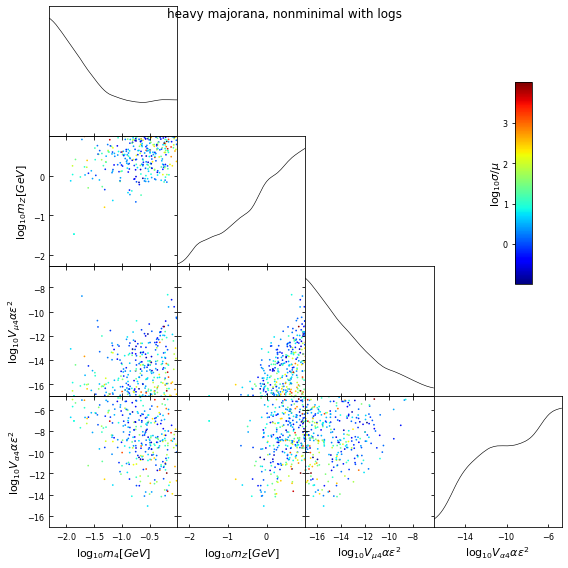

In [18]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_sigma/mu', savefile='corner_log10_sigma_mu')

Removed no burn in


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:409: RuntimeWarning: invalid value encountered in subtract
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/getdist/chains.py:763: RuntimeWarning: invalid value encountered in subtract
  return [self.samples[:, i] - means[i] for i in range(pars)]


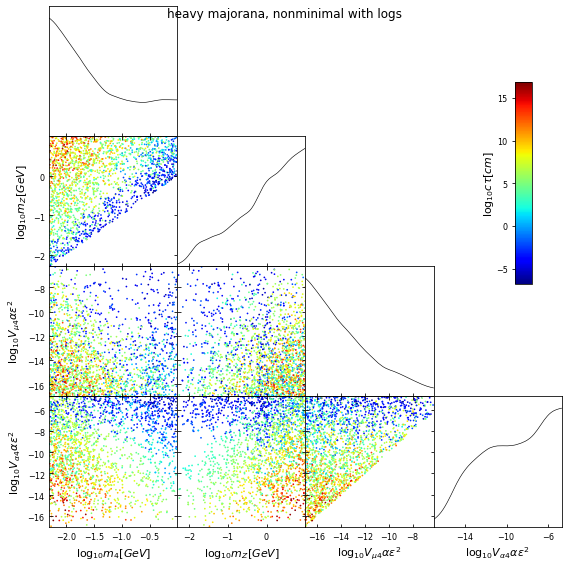

In [19]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_ctau', savefile='corner_log10_ctau')